# **Installs and Imports**

In [1]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install newspaper3k nltk
!pip install googlesearch-python
!pip install pmdarima
!pip install missingno
!pip install xgboost
!pip install tensorflow


In [2]:
# Importing necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
import missingno as msno

import pylab
from pylab import rcParams

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats


from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import time
import nltk
import requests
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer

from fuzzywuzzy import fuzz
from newspaper import Article, ArticleException
from googlesearch import search
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import plotly.express as px
import plotly.graph_objects as go



import warnings
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arijit_neha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# **Get the data**

In [3]:
# Set dataset variables
stock = "NIFTY_Infy"
sector = "Nifty_sector"
fii = "FII"
dii = "DII"
STOCK_PATH = f"files/{stock}.csv" 
SECTOR_PATH = f"files/{sector}.csv"
FII_PATH = f"files/{fii}.csv"
DII_PATH = f"files/{dii}.csv"

def load_stock_data(file_path = STOCK_PATH):
  """ This function Creates a pandas dataframe from given stock CSV dataset """
  df = pd.read_csv(file_path)
  df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
  df = df.set_index('Date')
  return df

def load_sector_data(file_path = SECTOR_PATH):
  """ This function Creates a pandas dataframe from given sector CSV dataset """
  df = pd.read_csv(file_path)
  return df

def load_fii_data(file_path = FII_PATH):
  """ This function Creates a pandas dataframe from given fii CSV dataset """
  df = pd.read_csv(file_path)
  return df

def load_dii_data(file_path = DII_PATH):
  """ This function Creates a pandas dataframe from given dii CSV dataset """
  df = pd.read_csv(file_path)
  return df


In [4]:
# Run the function load_stock_data and take a quick look on the DataFrame
df_stock_raw = load_stock_data()
df_stock_raw.tail(5)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2021-04-26,UPL,EQ,585.40,587.10,597.9,585.90,590.6,590.65,591.78,3162291,1.870000e+14,46535,431594,0.1365
2021-04-27,UPL,EQ,590.65,591.10,605.2,589.40,597.0,597.45,598.49,4496811,2.690000e+14,104264,1256338,0.2794
2021-04-28,UPL,EQ,597.45,602.95,613.7,601.20,607.5,608.05,608.90,4983043,3.030000e+14,65061,937294,0.1881
2021-04-29,UPL,EQ,608.05,613.40,621.0,609.80,616.5,615.80,615.23,6257014,3.850000e+14,74611,1420467,0.2270
2021-04-30,UPL,EQ,615.80,610.80,621.0,604.05,606.0,606.90,613.09,3072295,1.880000e+14,42385,664774,0.2164


In [5]:
# Finding all categories Symbol is holding in stock dataframe
print("Multiple categories of Symbol field in stock dataframe: ")
df_stock_raw["Symbol"].value_counts()

Multiple categories of Symbol field in stock dataframe: 


Symbol
ADANIPORTS    577
BHARTIARTL    577
DRREDDY       577
EICHERMOT     577
HDFCBANK      577
INFY          577
ITC           577
NTPC          577
ONGC          577
TATASTEEL     577
TITAN         577
ULTRACEMCO    577
UPL           577
Name: count, dtype: int64

In [6]:
# Run the function load_sector_data and take a quick look on the DataFrame
df_sector = load_sector_data()
print(df_sector.head(50))

# Filtering one Company out of this list
df_stock_raw_temp = df_stock_raw.reset_index()
# df_stock_raw_temp = df_stock_raw_temp.query('Symbol== "INFY"')

df_sector = df_sector.query("Symbol =='INFY'")
df_stock_raw_temp = df_stock_raw_temp.query('Symbol== "INFY"')

                               Company      Symbol                Industry
0                 HDFC Bank (HDFCBANK)    HDFCBANK      Financial Services
1                       Infosys (INFY)        INFY  Information Technology
2                            ITC (ITC)         ITC                    FMCG
3           Bharti Airtel (BHARTIARTL)  BHARTIARTL       Telecommunication
4                Titan Company (TITAN)       TITAN       Consumer Durables
5               Tata Steel (TATASTEEL)   TATASTEEL         Metals & Mining
6        UltraTech Cement (ULTRACEMCO)  ULTRACEMCO  Construction Materials
7                          NTPC (NTPC)        NTPC                   Power
8     Adani Ports and SEZ (ADANIPORTS)  ADANIPORTS                Services
9       Oil & Natural Gas Corp. (ONGC)        ONGC               Oil & Gas
10  Dr. Reddy's Laboratories (DRREDDY)     DRREDDY              Healthcare
11           Eicher Motors (EICHERMOT)   EICHERMOT              Automobile
12                       

In [7]:
# Load FII data and create dataframe through load_fii_data() function
df_fii = load_fii_data()

#Load DII data and create dataframe through load_dii_data() function
df_dii = load_dii_data()

# **Data Discovery, EDA , FE**

In [8]:
# Using info() method to get a quick description of the stock data
df_stock_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7501 entries, 2019-01-01 to 2021-04-30
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              7501 non-null   object 
 1   Series              7501 non-null   object 
 2   Prev Close          7501 non-null   float64
 3   Open                7501 non-null   float64
 4   High                7501 non-null   float64
 5   Low                 7501 non-null   float64
 6   Last                7501 non-null   float64
 7   Close               7501 non-null   float64
 8   VWAP                7501 non-null   float64
 9   Volume              7501 non-null   int64  
 10  Turnover            7501 non-null   float64
 11  Trades              7501 non-null   int64  
 12  Deliverable Volume  7501 non-null   int64  
 13  %Deliverble         7501 non-null   float64
dtypes: float64(9), int64(3), object(2)
memory usage: 879.0+ KB


In [9]:
# Using info() method to get a quick description of the sector data
df_sector.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 1 to 1
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Company   1 non-null      object
 1   Symbol    1 non-null      object
 2   Industry  1 non-null      object
dtypes: object(3)
memory usage: 32.0+ bytes


In [10]:
# Finding the summary of numeric fields
df_stock_raw_temp.describe()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,577,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,5.770000e+02,5.770000e+02,5.770000e+02,5.770000e+02,577.000000
mean,2020-03-01 11:11:20.069324032,878.350693,879.258492,890.009792,869.341768,879.846187,879.555893,879.768544,9.751012e+06,8.513570e+14,1.865238e+05,4.894523e+06,0.515412
min,2019-01-01 00:00:00,526.450000,509.250000,558.000000,509.250000,529.150000,526.450000,531.330000,1.136144e+06,1.290000e+14,3.676900e+04,4.469470e+05,0.165900
25%,2019-07-31 00:00:00,720.850000,720.000000,726.800000,712.600000,721.300000,721.050000,720.090000,6.092028e+06,4.960000e+14,1.253150e+05,3.096074e+06,0.448200
50%,2020-03-02 00:00:00,771.350000,771.600000,778.850000,764.500000,772.000000,771.450000,771.580000,7.926895e+06,6.830000e+14,1.617490e+05,4.108547e+06,0.520500
75%,2020-09-29 00:00:00,1011.000000,1018.000000,1028.000000,1005.000000,1013.850000,1011.450000,1016.650000,1.095492e+07,1.010000e+15,2.146850e+05,5.754904e+06,0.588500
max,2021-04-30 00:00:00,1441.050000,1474.000000,1477.550000,1430.050000,1441.000000,1441.050000,1441.230000,9.043339e+07,8.320000e+15,1.643015e+06,5.775916e+07,0.789800
std,NaN,229.751783,231.018181,232.874279,228.251563,230.704965,230.421822,230.277639,7.391332e+06,6.522003e+14,1.175618e+05,3.588231e+06,0.102997


In [11]:
df_stock_raw_temp.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
2885,2019-01-01,INFY,EQ,658.95,660.95,666.3,654.15,665.95,665.05,660.66,2943390,1.940000e+14,45422,1282161,0.4356
2886,2019-01-02,INFY,EQ,665.05,666.00,674.0,662.05,668.00,669.05,669.97,7416655,4.970000e+14,108094,3880800,0.5233
2887,2019-01-03,INFY,EQ,669.05,672.00,677.0,663.10,668.00,669.15,669.66,6827249,4.570000e+14,125781,3676359,0.5385
2888,2019-01-04,INFY,EQ,669.15,671.75,673.9,651.00,660.25,661.05,660.17,7889310,5.210000e+14,187590,3747741,0.4750
2889,2019-01-07,INFY,EQ,661.05,665.00,673.6,661.50,671.70,671.70,667.51,8046340,5.370000e+14,132736,4711672,0.5856


In [12]:
df_stock_raw_temp["Date"] = pd.to_datetime(df_stock_raw_temp["Date"],format='%d-%m-%Y')
df_stock_raw_temp = df_stock_raw_temp.sort_values(by="Date")

df_stock_raw_temp['rollMean'] = df_stock_raw_temp.Close.rolling(window=12).mean()
df_stock_raw_temp['rollStd'] = df_stock_raw_temp.Close.rolling(window=12).std()
df_stock_raw_temp.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,rollMean,rollStd
3457,2021-04-26,INFY,EQ,1333.80,1332.25,1351.3,1321.00,1345.0,1343.55,1343.19,7088606,9.520000e+14,130375,4218129,0.5951,1382.570833,41.143035
3458,2021-04-27,INFY,EQ,1343.55,1346.00,1353.0,1340.15,1347.5,1348.50,1346.89,3636115,4.900000e+14,145974,1871084,0.5146,1375.762500,39.261693
3459,2021-04-28,INFY,EQ,1348.50,1358.00,1359.5,1344.60,1355.8,1356.00,1353.45,4879234,6.600000e+14,137376,2857134,0.5856,1368.775000,33.916653
3460,2021-04-29,INFY,EQ,1356.00,1368.00,1369.0,1351.40,1356.0,1356.35,1360.05,5412357,7.360000e+14,119277,3130945,0.5785,1361.716667,25.202086
3461,2021-04-30,INFY,EQ,1356.35,1346.30,1373.9,1345.90,1348.6,1354.35,1361.16,8354677,1.140000e+15,131718,5408113,0.6473,1355.766667,15.123031


In [13]:
train_set = df_stock_raw_temp[: round(len(df_stock_raw_temp)*0.99)]  # staring to 99% value
test_set = df_stock_raw_temp[round(len(df_stock_raw_temp)*0.99):]       # from 1% till end

In [14]:
train_set.info()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571 entries, 2885 to 3455
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                571 non-null    datetime64[ns]
 1   Symbol              571 non-null    object        
 2   Series              571 non-null    object        
 3   Prev Close          571 non-null    float64       
 4   Open                571 non-null    float64       
 5   High                571 non-null    float64       
 6   Low                 571 non-null    float64       
 7   Last                571 non-null    float64       
 8   Close               571 non-null    float64       
 9   VWAP                571 non-null    float64       
 10  Volume              571 non-null    int64         
 11  Turnover            571 non-null    float64       
 12  Trades              571 non-null    int64         
 13  Deliverable Volume  571 non-null    int64         


In [15]:
# Print the size for train and test set
print(f"Train set size: {len(train_set)}\nTest set size: {len(test_set)}")

Train set size: 571
Test set size: 6


**Discover and Visualize the Data to Gain Insights**

In [16]:
# Create a copy of training set
df_train = train_set.copy()

In [17]:
# Finding correlation
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns
corr_mat = df_train[numeric_columns].corr()
target_corr = corr_mat["Close"].sort_values(ascending=False)
top_features = target_corr[1:8].index
target_corr


Close                 1.000000
Last                  0.999958
VWAP                  0.999723
High                  0.999248
Low                   0.999198
Open                  0.998164
Prev Close            0.997179
rollMean              0.990288
Turnover              0.314866
rollStd               0.239490
Trades                0.089940
Volume               -0.029489
Deliverable Volume   -0.106184
%Deliverble          -0.225189
Name: Close, dtype: float64

Text(0.5, 1.0, 'Correlation of Variables ')

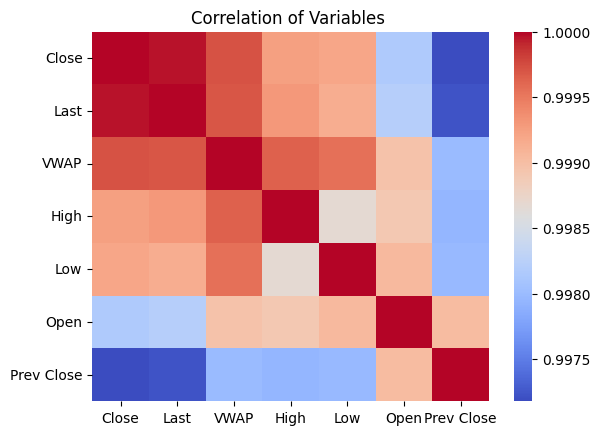

In [18]:
# Representing the correlation through a heat map
corr_mat_close = df_train[["Close", "Last", "VWAP", "High", "Low", "Open", "Prev Close"]].corr()
sns.heatmap(corr_mat_close, cmap = 'coolwarm' , annot = False)
plt.title('Correlation of Variables ')

# **Prepare the Data for Machine Learning Algorithms**

In [19]:
# Creating a clean training set and separating predictors and labels
df_train_pred = train_set.drop("Close", axis=1)
df_train_label = train_set["Close"].copy()

In [20]:
# Creating a clean test set and separating predictors and labels
df_test_pred = test_set.drop("Close", axis=1)
df_test_label = test_set["Close"].copy()

In [21]:
# Best practices
#DataFrameSelector	will	transform	the	data	by	selecting	the	desired	attributes,	dropping	the	rest, and	converting	the	resulting	DataFrame	to	a	NumPy	array.
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

# **Pipeline on train and test data**

In [22]:
# Creating pipeline for numerical and categorical features and join the pipeline
## Since	imputer strategy median	can	only	be	computed	on	numerical	attributes,	we	need	to	create	a	copy	of	the	data without	the	text	attribute
train_num = df_train_pred.select_dtypes(include=['float64', 'int64']).columns
train_cat = df_train_pred.select_dtypes(include=['object']).columns
num_attribs = list(train_num)
cat_attribs = list(train_cat)

# Numeric pipeline
num_pipeline	=	Pipeline([
								('selector',	DataFrameSelector(num_attribs)),
								('imputer',	SimpleImputer(strategy="median")),
								('std_scaler',	StandardScaler()),
				])

# Categorical pipeline
cat_pipeline	=	Pipeline([
								('selector',	DataFrameSelector(cat_attribs)),
								('one_hot_encoder', OneHotEncoder(sparse_output=False)),
				])


# Full pipeline
full_pipeline	=	ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

# Run whole pipeline
train_prepared = full_pipeline.fit_transform(df_train_pred)

In [23]:
# Checking the shape for the prepared data
train_prepared.shape

(571, 15)

In [24]:
test_prepared = full_pipeline.transform(df_test_pred)

In [25]:
test_prepared.shape

(6, 15)

In [26]:
pd.DataFrame(data = test_prepared).head(7)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.117242,2.065374,2.024661,2.082267,2.025123,2.054845,-0.333629,0.196102,-0.196944,-0.218032,0.473830,2.366505,1.338546,1.0,1.0
1,2.040563,2.018001,2.037333,2.037640,2.074099,2.071207,-0.364342,0.153331,-0.480308,-0.191684,0.779217,2.340832,1.422858,1.0,1.0
2,2.083778,2.078595,2.044762,2.123101,2.085130,2.087569,-0.830119,-0.552377,-0.348070,-0.843718,-0.001216,2.309759,1.293246,1.0,1.0
3,2.105718,2.131477,2.073167,2.142960,2.121752,2.116579,-0.662409,-0.292701,-0.420958,-0.569783,0.687116,2.277868,0.925010,1.0,1.0
4,2.138960,2.175545,2.114681,2.173306,2.122635,2.145765,-0.590485,-0.176610,-0.574390,-0.493715,0.618283,2.245653,0.324638,1.0,1.0
5,2.140511,2.079917,2.136093,2.148761,2.089984,2.150674,-0.193535,0.440503,-0.468923,0.138906,1.285287,2.218497,-0.369739,1.0,1.0


# **Select and Train a Model**

# Sentiment Analysis

Before working with trained prepare data, lets have a look at market sentiment for these companies through **sector dataframe**

In [27]:
# Get company names in 'symbol' variable
symbols = df_sector['Symbol']

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def fetch_article_text(url):
    ''' This function fetchs article text from a webpage using newspaper3k '''
    article = Article(url)
    article.download()
    article.parse()
    return article.text

def analyze_sentiment_for_symbol(symbol):
    ''' This function is to analyze sentiment for news headlines for a given symbol '''
    query = f"{symbol} independent market sentiment"

    # Perform a Google search and get the first result
    for url in search(query, num_results=10):
        try:
            # Fetch the article text from the webpage
            article_text = fetch_article_text(url)

            # Perform sentiment analysis on the article text
            sentiment_score = sia.polarity_scores(article_text)['compound']

            # Classify overall sentiment as positive, negative, or neutral
            overall_sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

            return overall_sentiment
        except ArticleException as e:
            print(f"Failed to download article from {url}. Error: {e}")

    return None

# Analyze sentiment for the symbols
results = []
for symbol in symbols:
  sentiment = analyze_sentiment_for_symbol(symbol)
  if sentiment:
      result_entry = {"Symbol":symbol.upper(), "Sentiment": sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Symbol": symbol.upper(), "Sentiment": "Not found"}
      results.append(result_entry)
# Create a DataFrame from the results list
stock_sentiments = pd.DataFrame(results)

stock_sentiments.head(13)

,Symbol,Sentiment
0,INFY,Positive


Now, lets have a look at market sentiment for these sectors through **sector dataframe**

In [28]:
symbols = df_sector['Symbol']
# Get Industry names in 'Industry' variable
sectors = df_sector['Industry'].unique()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def fetch_article_text(url):
    ''' This function fetchs article text from a webpage using newspaper3k '''
    article = Article(url)
    article.download()
    article.parse()
    return article.text

def analyze_sentiment_for_sector(sector):
    ''' This function is to analyze sentiment for news headlines for a given symbol '''
    query = f"{sector} independent market sentiment"

    # Perform a Google search and get the first result
    for url in search(query, num_results=10):
        try:
            # Fetch the article text from the webpage
            article_text = fetch_article_text(url)

            # Perform sentiment analysis on the article text
            sentiment_score = sia.polarity_scores(article_text)['compound']

            # Classify overall sentiment as positive, negative, or neutral
            overall_sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

            return overall_sentiment
        except ArticleException as e:
            print(f"Failed to download article from {url}. Error: {e}")

    return None

# Analyze sentiment for the symbols
results = []
for sector in sectors:
  sentiment = analyze_sentiment_for_sector(sector)
  if sentiment:
      result_entry = {"Industry":sector, "Sentiment": sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Industry": sector, "Sentiment": "Not found"}
      results.append(result_entry)
# Create a DataFrame from the results list
industry_sentiments = pd.DataFrame(results)

industry_sentiments.head(13)

,Industry,Sentiment
0,Information Technology,Positive


FII Activity

In [29]:
# Get company names in 'symbol' variable
symbols = df_sector['Symbol']

# Analyze sentiment for the symbols
results = []

def analyze_fii_for_symbol(symbol):
    ''' This function is to analyze FII activity for a given symbol '''
    ' Read the FII data'
    index, match_present = match_index(symbol)
    if match_present:
      if df_fii.values[index][1] > df_fii.values[index][2]:
        return 'Positive'
      elif df_fii.values[index][1] == df_fii.values[index][2]:
        return 'Neutral'
      else:
        return 'Negative'
    else:
      return 'None'

def match_index(symbol):
  match_present = 0
  for i in range(len(df_fii)):
    if symbol == df_fii.values[i][0]:
      match_present = 1
      return i, match_present
  return i, 0

for symbol in symbols:
  fii_sentiment = analyze_fii_for_symbol(symbol)
  if fii_sentiment:
      result_entry = {"Symbol":symbol.upper(), "Sentiment_FII": fii_sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Symbol": symbol.upper(), "Sentiment_FII": "Not found"}
      results.append(result_entry)
# Create a DataFrame from the results list
fii_sentiments = pd.DataFrame(results)

fii_sentiments.head(13)

,Symbol,Sentiment_FII
0,INFY,Positive


DII Activity

In [30]:
# Get company names in 'symbol' variable
symbols = df_sector['Symbol']

# Analyze sentiment for the symbols
results = []
def analyze_dii_for_symbol(symbol):
    ''' This function is to analyze DII activity for a given symbol '''
    ' Read the FII data'
    index, match_present = match_index(symbol)
    if match_present:
      if df_dii.values[index][1] > df_dii.values[index][2]:
        return 'Positive'
      elif df_dii.values[index][1] == df_dii.values[index][2]:
        return 'Neutral'
      else:
        return 'Negative'
    else:
      return 'None'

def match_index(symbol):
  match_present = 0
  for i in range(len(df_dii)):
    if symbol == df_dii.values[i][0]:
      match_present = 1
      return i, match_present
  return i, 0

for symbol in symbols:
  dii_sentiment = analyze_dii_for_symbol(symbol)
  if dii_sentiment:
      result_entry = {"Symbol":symbol.upper(), "Sentiment_DII": dii_sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Symbol": symbol.upper(), "Sentiment_DII": "Not found"}
      results.append(result_entry)
# Create a DataFrame from the results list
dii_sentiments = pd.DataFrame(results)

dii_sentiments.head(13)

,Symbol,Sentiment_DII
0,INFY,Positive


Combining both sentiments

In [31]:
# Merge df_sector and stock_sentiments
df_sector_stock_Sentiments = pd.merge(df_sector, stock_sentiments, on='Symbol', how='inner')
df_temp_sentiments = pd.merge(df_sector_stock_Sentiments,fii_sentiments)
df_dii_sentiments = pd.merge(df_temp_sentiments,dii_sentiments)
# Merge df_sector_stock_Sentiments and industry_sentiments
df_final_data = pd.merge(df_dii_sentiments, industry_sentiments, on='Industry', how='inner', suffixes=('_Symbol', '_Industry'))


def calculate_overall_sentiment(row):
    ''' Function to calculate overall sentiment '''
    display(row)
    positive_cnt = (row['Sentiment_Symbol'] == 'Positive') + (row['Sentiment_Industry'] == 'Positive') + (row['Sentiment_FII'] == 'Positive') + (row['Sentiment_DII'] == 'Positive')
    negative_cnt = (row['Sentiment_Symbol'] == 'Negative') + (row['Sentiment_Industry'] == 'Negative') + (row['Sentiment_FII'] == 'Negative') + (row['Sentiment_DII'] == 'Negative')
    if positive_cnt > negative_cnt:
        return 'Positive'
    elif positive_cnt < negative_cnt:
        return 'Negative'
    else:
        return 'Neutral'

df_final_data["Overall_Sentiment"] = df_final_data.apply(calculate_overall_sentiment, axis=1)

# Create a new dataframe with the desired information
df_combined_sentiments = df_final_data[['Symbol', 'Industry', 'Overall_Sentiment']]

df_combined_sentiments.head(65)


Company                       Infosys (INFY)
Symbol                                  INFY
Industry              Information Technology
Sentiment_Symbol                    Positive
Sentiment_FII                       Positive
Sentiment_DII                       Positive
Sentiment_Industry                  Positive
Name: 0, dtype: object

,Symbol,Industry,Overall_Sentiment
0,INFY,Information Technology,Positive


# ARIMA & SARIMAX


In [32]:
def stationarity(df, var):
    df['rollMean'] = df[var].rolling(window=3).mean()
    df['rollStd'] = df[var].rolling(window=3).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(df[var], autolag = 'AIC')
    stats= pd.Series(adfTest[0:4], index = ['Test Statistics', 'p-value', '#lags used', 'numbers of observations used'])
    print(stats)
    for key,values in adfTest[4].items():
        print("criticality",key,":",values)

    sns.lineplot( data = df, x = df.index, y = var, label = "Original")
    sns.lineplot( data = df, x = df.index, y = 'rollMean', label = "Mean")
    sns.lineplot( data = df, x = df.index, y = 'rollStd', label = "Variance")

# test statistics < critical value , then stationary

Test Statistics                   0.096518
p-value                           0.965823
#lags used                        7.000000
numbers of observations used    569.000000
dtype: float64
criticality 1% : -3.4418948967017475
criticality 5% : -2.8666329082535222
criticality 10% : -2.569482366838501


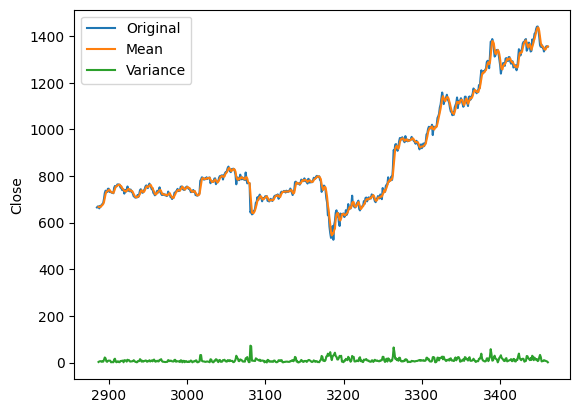

In [33]:
stationarity(df_stock_raw_temp, "Close")

In [34]:
# Convert Non- Stationary data to stationary data
# Method 1 - Time shift
air_df = df_stock_raw_temp[['Close']]

air_df['shift'] = air_df.Close.shift()
air_df['shiftDiff'] = air_df.Close - air_df['shift']


# Method 2 - Log value
air_df['log'] = np.log(df_stock_raw_temp['Close'])

air_df.head()

,Close,shift,shiftDiff,log
2885,665.05,NaN,NaN,6.499862
2886,669.05,665.05,4.00,6.505859
2887,669.15,669.05,0.10,6.506008
2888,661.05,669.15,-8.10,6.493829
2889,671.70,661.05,10.65,6.509812


Test Statistics                -8.869154e+00
p-value                         1.413404e-14
#lags used                      6.000000e+00
numbers of observations used    5.690000e+02
dtype: float64
criticality 1% : -3.4418948967017475
criticality 5% : -2.8666329082535222
criticality 10% : -2.569482366838501


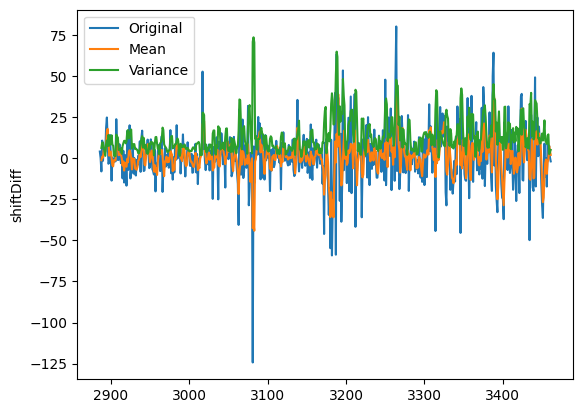

In [35]:
stationarity(air_df.dropna(), "shiftDiff")

Test Statistics                  -0.120527
p-value                           0.947355
#lags used                        9.000000
numbers of observations used    566.000000
dtype: float64
criticality 1% : -3.441956369604407
criticality 5% : -2.8666599744723045
criticality 10% : -2.5694967895716014


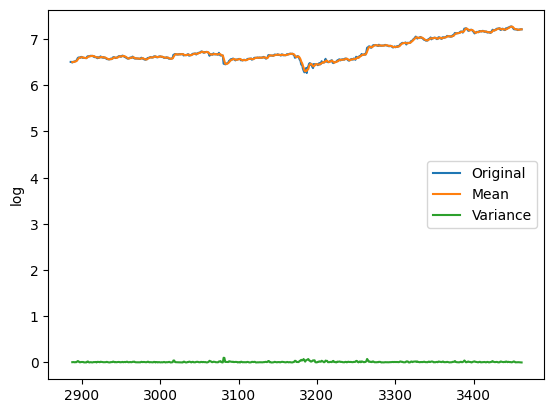

In [36]:
stationarity(air_df.dropna(), "log")

In [37]:
# Preparing Data to identify order

#creating a new DataFrame that contains only the 'Close' column
df_Stocks_Close = air_df[['Close']].copy(deep=True)

# First Diff - commonly used to make the time series data stationary, for ARIMA models.
df_Stocks_Close['firstDiff'] = df_Stocks_Close['Close'].diff()

# Seasonal Difference - by subtracting the value from 12 months ago from the current value.
# useful for addressing seasonality in the data
df_Stocks_Close['Diff12'] = df_Stocks_Close['Close'].diff(12)

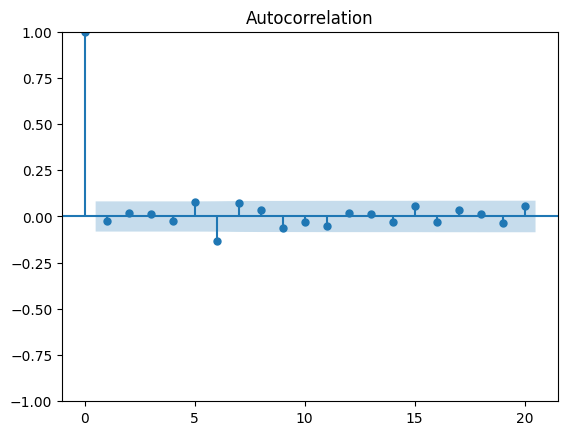

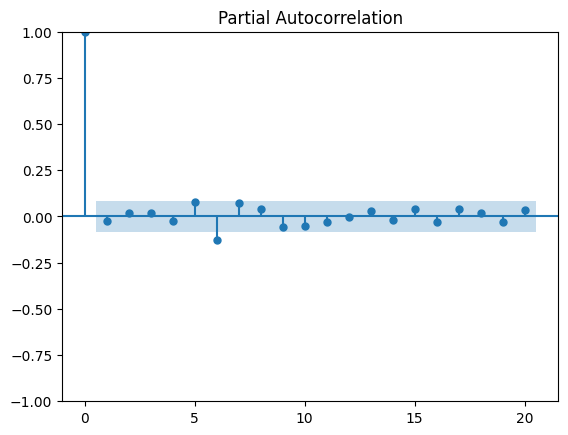

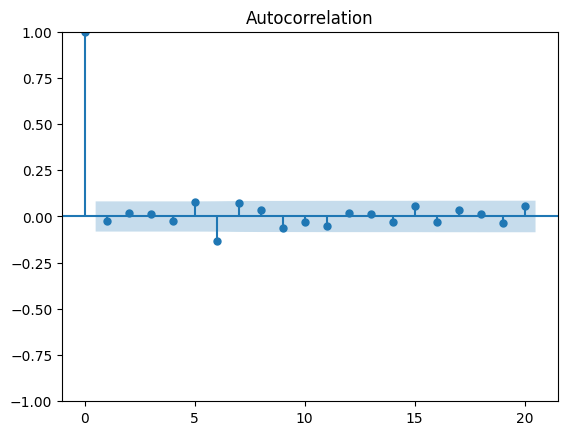

In [38]:
# Order for ARIMA - p value using PACF
plot_pacf(df_Stocks_Close['firstDiff'].dropna(), lags=20) #why lags is 20 ?
# Order for ARIMA - qvalue using ACF
plot_acf(df_Stocks_Close['firstDiff'].dropna(), lags=20) #why lags is 20 ?

In [39]:
df_Stocks_Close.reset_index(inplace= True)

#Train m test
train = df_Stocks_Close[: round(len(df_Stocks_Close)*0.90)]  # staring to 80% value
test = df_Stocks_Close[round(len(df_Stocks_Close)*0.90):]       # from 80% till end



In [40]:
# Manually train ARIMA on the training data
order = (6, 1, 6)  # You may need to adjust the order based on your data characteristics

model = ARIMA(train['Close'], order=order)
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

df_Stocks_Close["arimaPred"] = predictions

# Display predictions
df_Stocks_Close.tail()

,index,Close,firstDiff,Diff12,arimaPred
572,3457,1343.55,9.75,-67.50,1274.393920
573,3458,1348.50,4.95,-81.70,1273.232743
574,3459,1356.00,7.50,-83.85,1272.849320
575,3460,1356.35,0.35,-84.70,1274.268698
576,3461,1354.35,-2.00,-71.40,1274.009287


In [41]:
RMSE_ARIMA = np.sqrt(mean_squared_error(test['Close'], predictions))
print(RMSE_ARIMA)

81.16337946750245


In [42]:
modelResult = [{"modelName": "ARIMA", 'RMSE': RMSE_ARIMA}]
Result = pd.DataFrame(modelResult)
print(Result)


  modelName       RMSE
0     ARIMA  81.163379


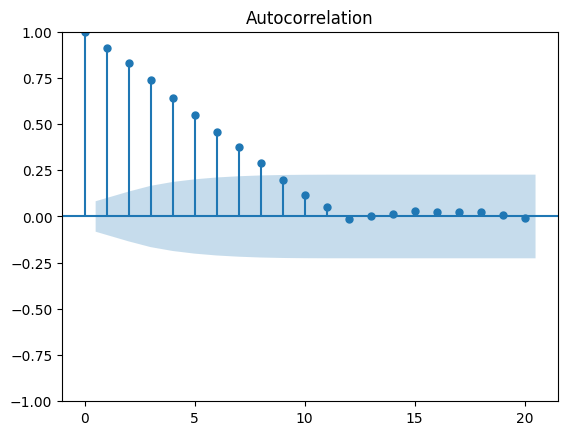

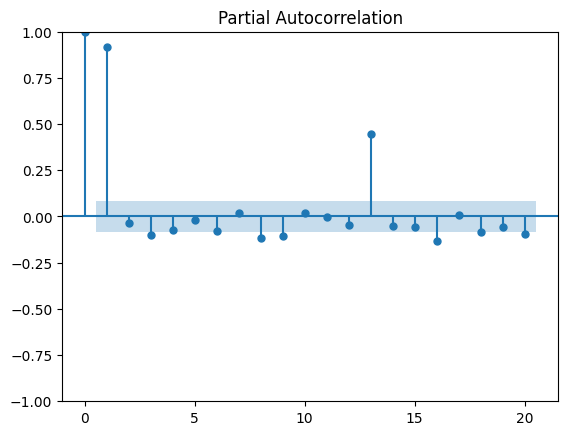

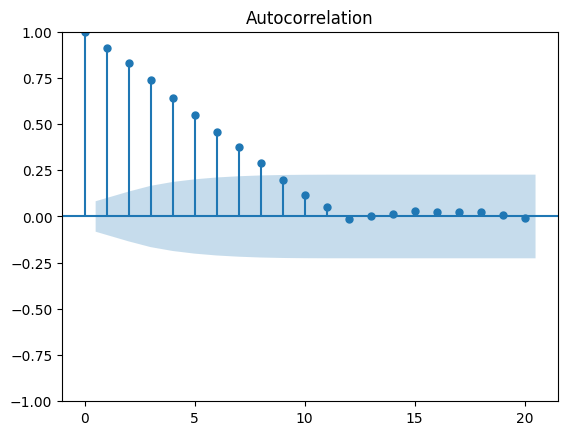

In [43]:
# Order for SARIMAX - p value using PACF
# Order for SARIMAX - q value using ACF

plot_pacf(df_Stocks_Close['Diff12'].dropna(), lags=20)
plot_acf(df_Stocks_Close['Diff12'].dropna(), lags=20)

In [44]:
# Training SARIMAX
model1 = SARIMAX(train['Close'], order=(6, 1, 6), seasonal_order=(1,1,6,12))

model_fit1 = model1.fit()

prediction1 = model_fit1.predict(start= test.index[0] , end = test.index[-1])


df_Stocks_Close['sarimaxPred'] = prediction1

In [45]:
df_Stocks_Close.tail()

,index,Close,firstDiff,Diff12,arimaPred,sarimaxPred
572,3457,1343.55,9.75,-67.50,1274.393920,1394.531461
573,3458,1348.50,4.95,-81.70,1273.232743,1392.061743
574,3459,1356.00,7.50,-83.85,1272.849320,1394.237136
575,3460,1356.35,0.35,-84.70,1274.268698,1398.100724
576,3461,1354.35,-2.00,-71.40,1274.009287,1400.737605


In [46]:
RMSE_SARIMAX = np.sqrt(mean_squared_error(test['Close'], prediction1))
SARIMAX_Result = [{"modelName": "SARIMAX", 'RMSE': RMSE_SARIMAX}]
SARIMAX_Result = pd.DataFrame(SARIMAX_Result)
print(SARIMAX_Result)

  modelName       RMSE
0   SARIMAX  33.193334


RMSE for ARIMA is  81.16337946750245
RMSE for SARIMAX is  33.193333886193805


<Axes: ylabel='Close'>

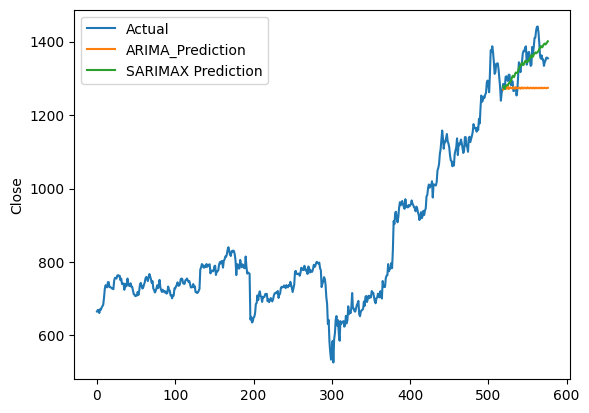

In [47]:
#Summary:

print("RMSE for ARIMA is ", RMSE_ARIMA)
print("RMSE for SARIMAX is ", RMSE_SARIMAX)


df_Stocks_Close.dropna()
sns.lineplot( data = df_Stocks_Close, x = df_Stocks_Close.index , y = df_Stocks_Close['Close'], label = "Actual")
sns.lineplot( data = df_Stocks_Close, x = df_Stocks_Close.index , y = df_Stocks_Close['arimaPred'],  label = "ARIMA_Prediction")
sns.lineplot( data = df_Stocks_Close, x = df_Stocks_Close.index , y = df_Stocks_Close['sarimaxPred'], label = "SARIMAX Prediction")

#RandomForestRegressor
Use RandomForestRegressor model to predict the closing price on train data and calculate RMSE

Random Forest - RMSE : 3.158727664476707


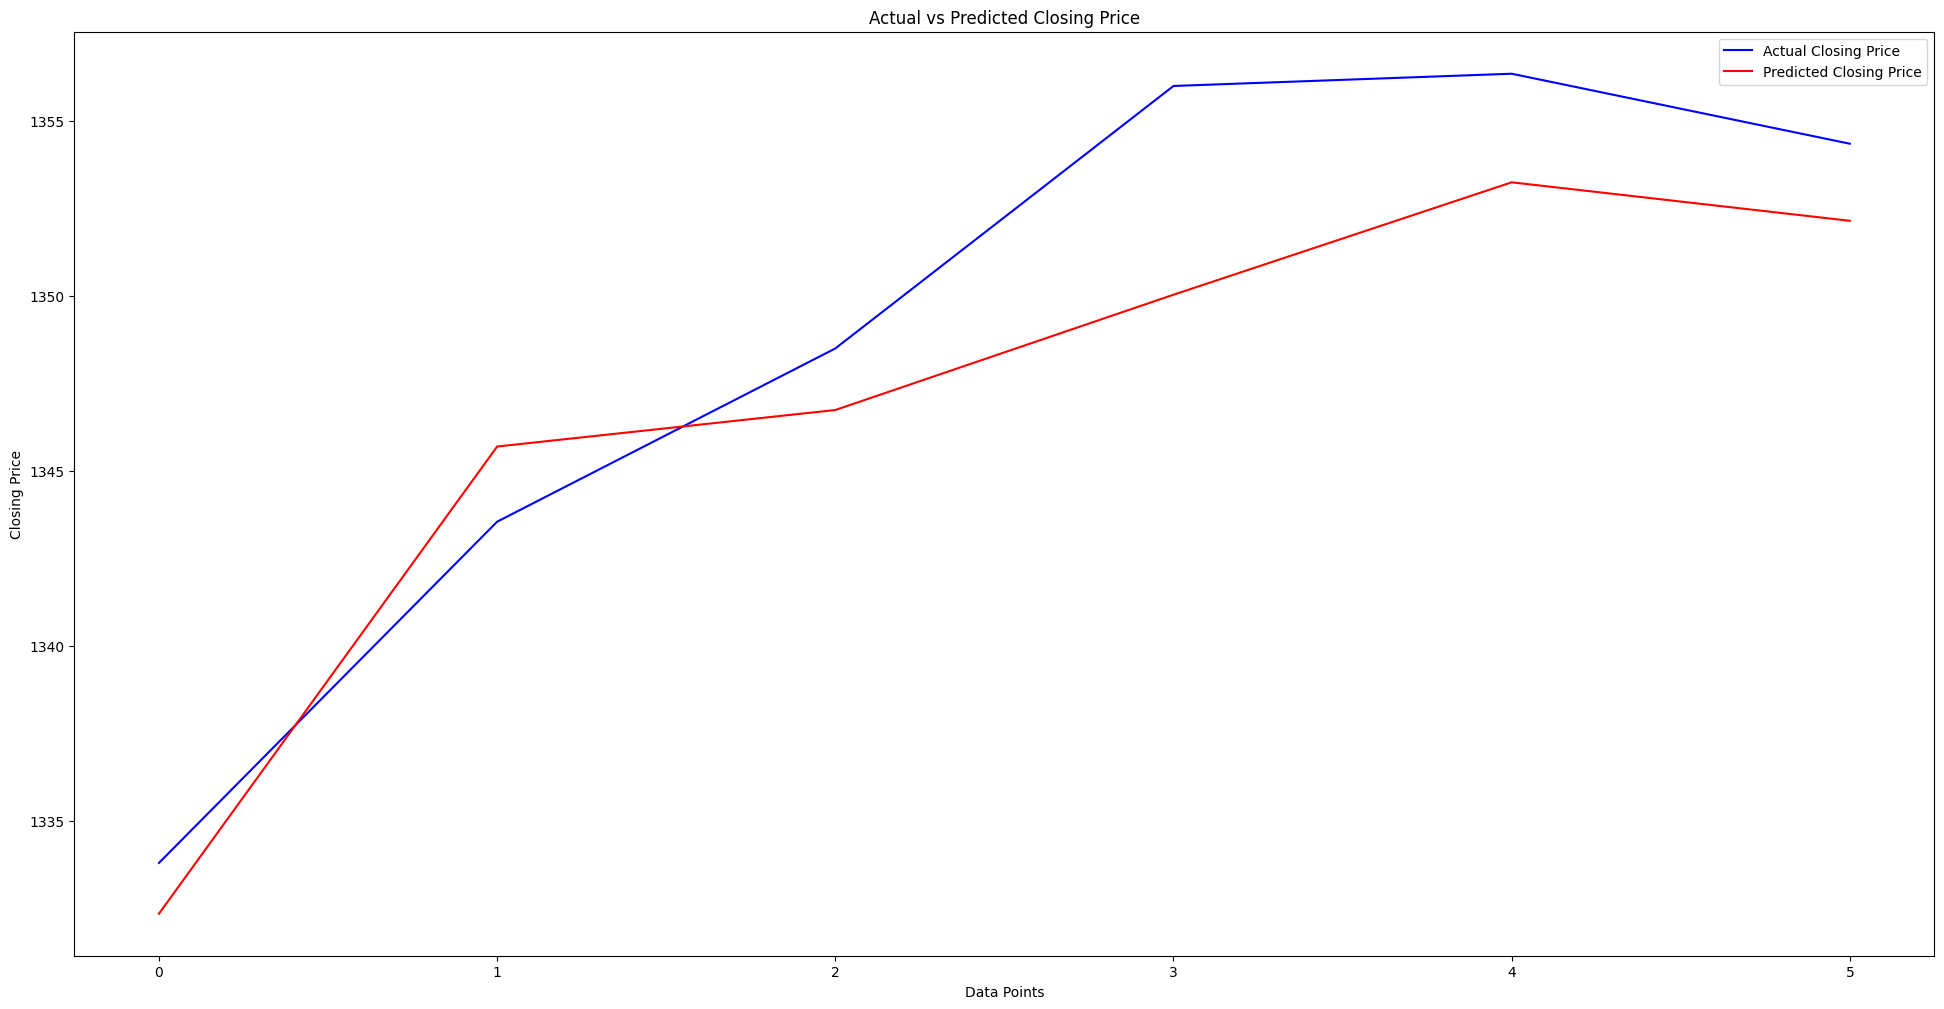

In [48]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_prepared, df_train_label)

# Make predictions on the test set
forest_predictions = forest_reg.predict(test_prepared)

# Evaluate the model
mse = mean_squared_error(df_test_label, forest_predictions)
rmse = np.sqrt(mse)

print(f'Random Forest - RMSE : {rmse}')

# Visualize actual and predicted values with two different lines
plt.figure(figsize=(24, 12))
plt.plot(df_test_label.values, label='Actual Closing Price', color='blue')
plt.plot(forest_predictions, label='Predicted Closing Price', color='red')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

Use gridSearchCV along with RandomForestRegressor to find best hyperparameters and model and calculate RMSE

Grid Search - RMSE: 6.467677326521456


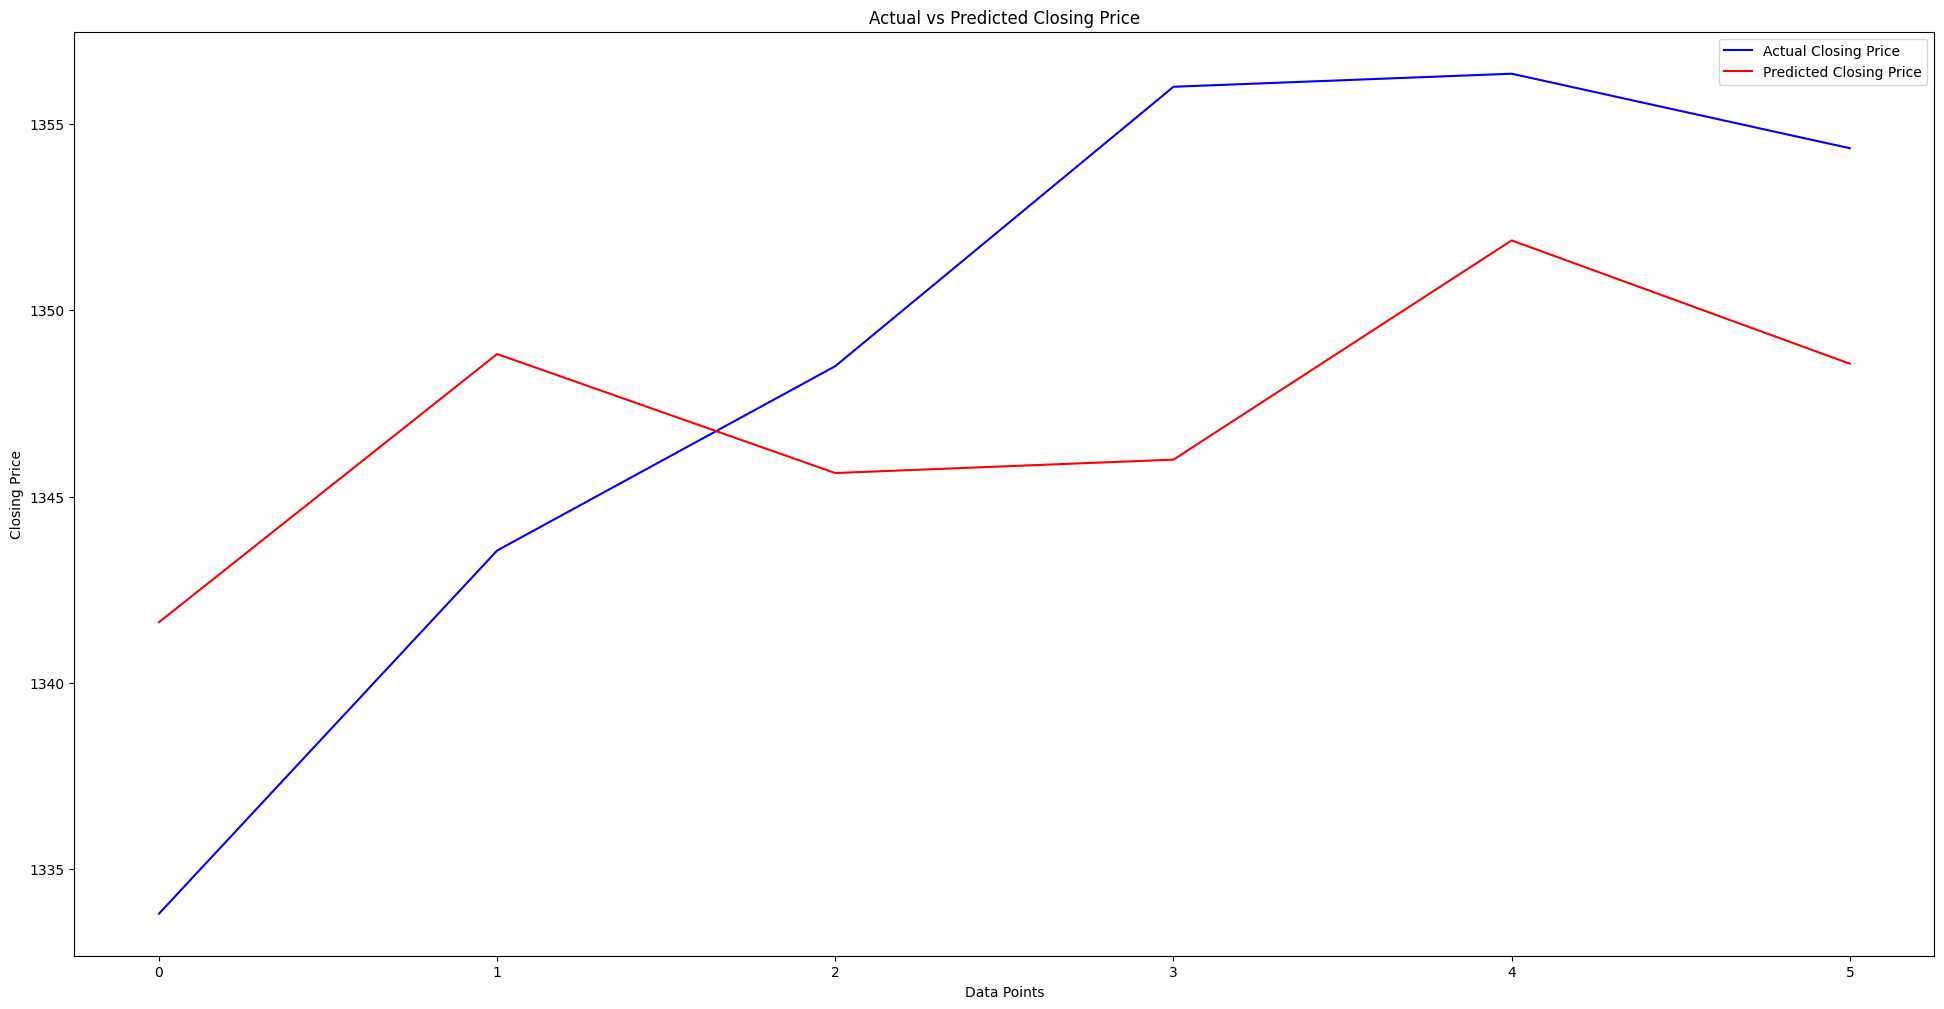

In [49]:
# Define the hyperparameter grid to search
param_grid = [
{'n_estimators': [10, 20, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [10, 20], 'max_features': [2, 3, 4]},
]

# Define the RandomForestRegressor
forest_reg = RandomForestRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')

# Fit the GridSearchCV to the data
grid_search.fit(train_prepared, df_train_label)

# Get the best estimator from the grid search
best_rf = grid_search.best_estimator_

# Make predictions on the test set using the best model
grid_predictions = best_rf.predict(test_prepared)

# Evaluate the model
grid_mse = mean_squared_error(df_test_label, grid_predictions)
grid_rmse = np.sqrt(grid_mse)
print(f'Grid Search - RMSE: {grid_rmse}')

# Visualize actual and predicted values with two different lines
plt.figure(figsize=(24, 12))
plt.plot(df_test_label.values, label='Actual Closing Price', color='blue')
plt.plot(grid_predictions, label='Predicted Closing Price', color='red')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

Use RandomizedSearchCV along with RandomForestRegressor to find best hyperparameters and model and calculate RMSE

Random Search - RMSE: 3.260203783252701


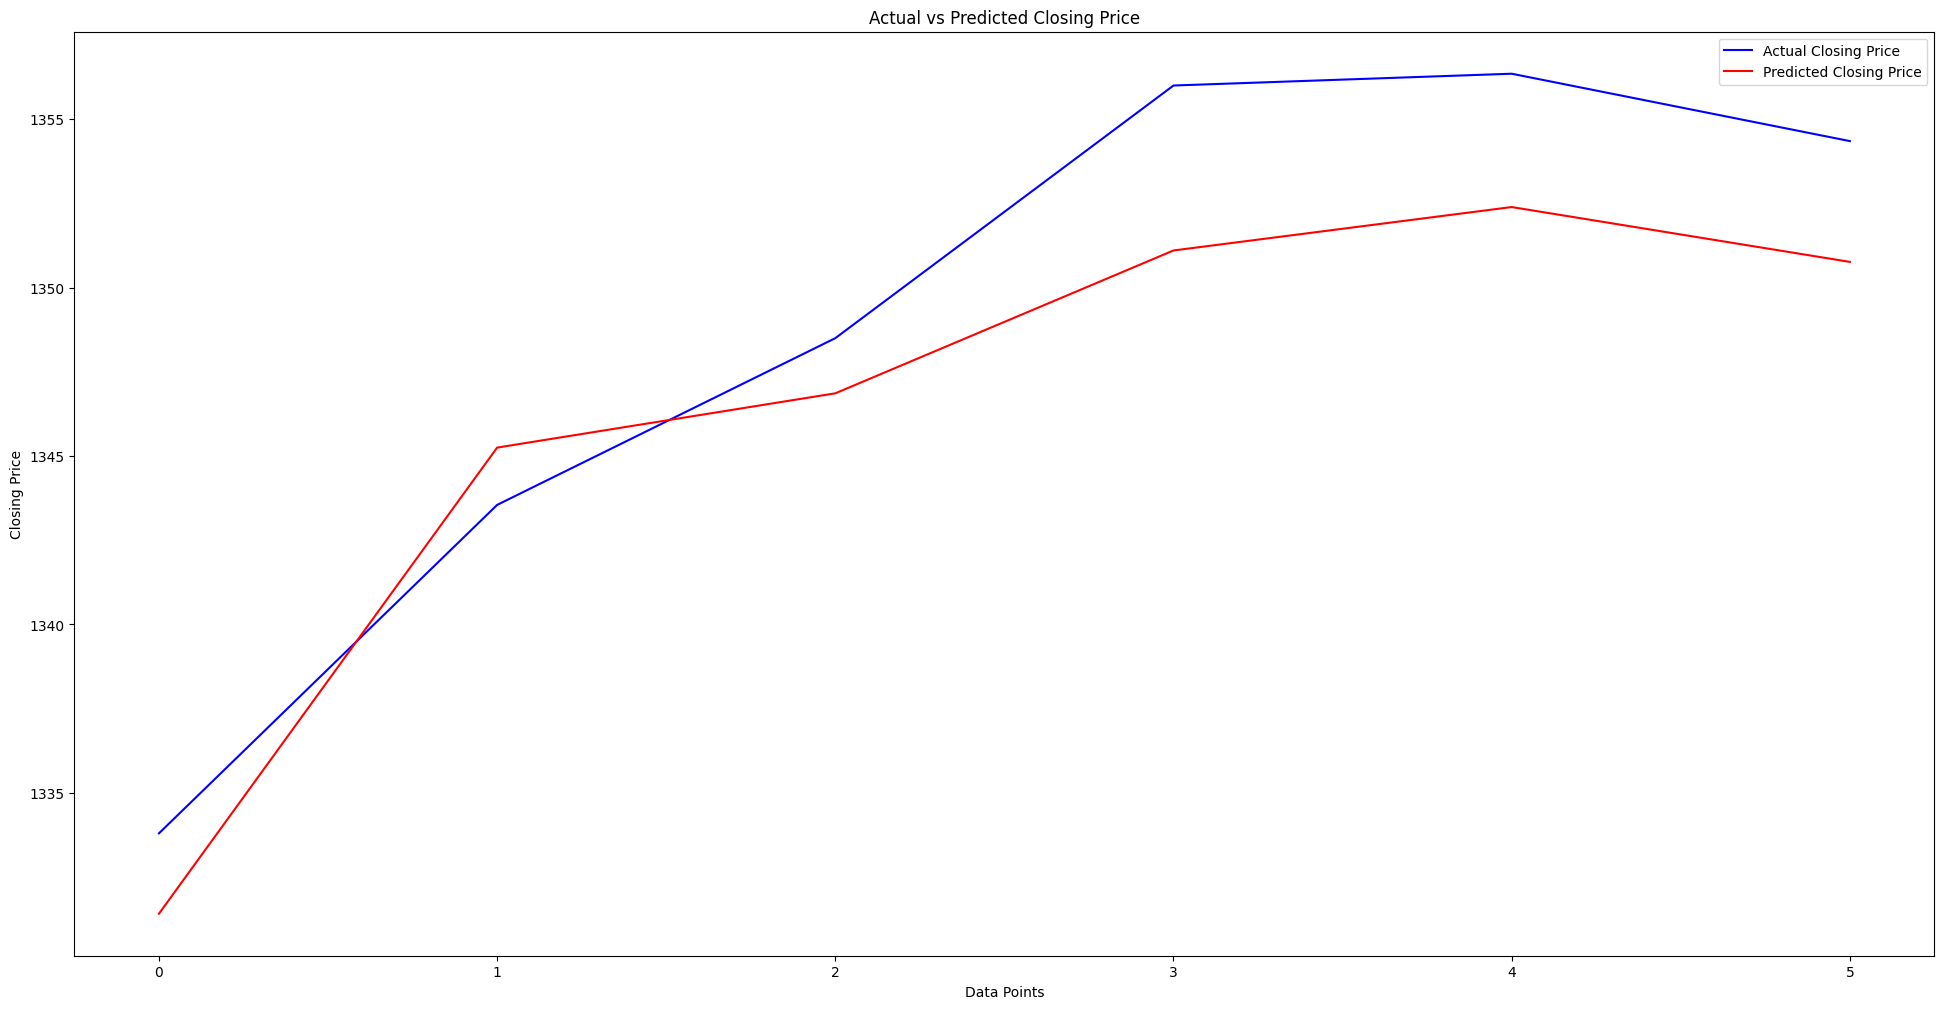

In [50]:
# Define the hyperparameter distribution
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(50, 150, num=5)],
    'max_depth': [None] + [int(x) for x in np.linspace(10, 50, num=5)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the RandomForestRegressor
forest_reg = RandomForestRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=forest_reg, param_distributions=param_dist, scoring='neg_mean_squared_error',
                                   n_iter=10, cv=5, random_state=42)

# Fit the RandomizedSearchCV to the data
random_search.fit(train_prepared, df_train_label)

# Get the best estimator from the grid search
best_rf = random_search.best_estimator_

# Make predictions on the test set using the best model
randomCV_predictions = best_rf.predict(test_prepared)

# Evaluate the model
randomCV_mse = mean_squared_error(df_test_label, randomCV_predictions)
randomCV_rmse = np.sqrt(randomCV_mse)
print(f'Random Search - RMSE: {randomCV_rmse}')

# Visualize actual and predicted values with two different lines
plt.figure(figsize=(24, 12))
plt.plot(df_test_label.values, label='Actual Closing Price', color='blue')
plt.plot(randomCV_predictions, label='Predicted Closing Price', color='red')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

Use LinearRegression model to predict the closing price on train data and calculate RMSE

Mean Squared Error: 1.6676109739084375


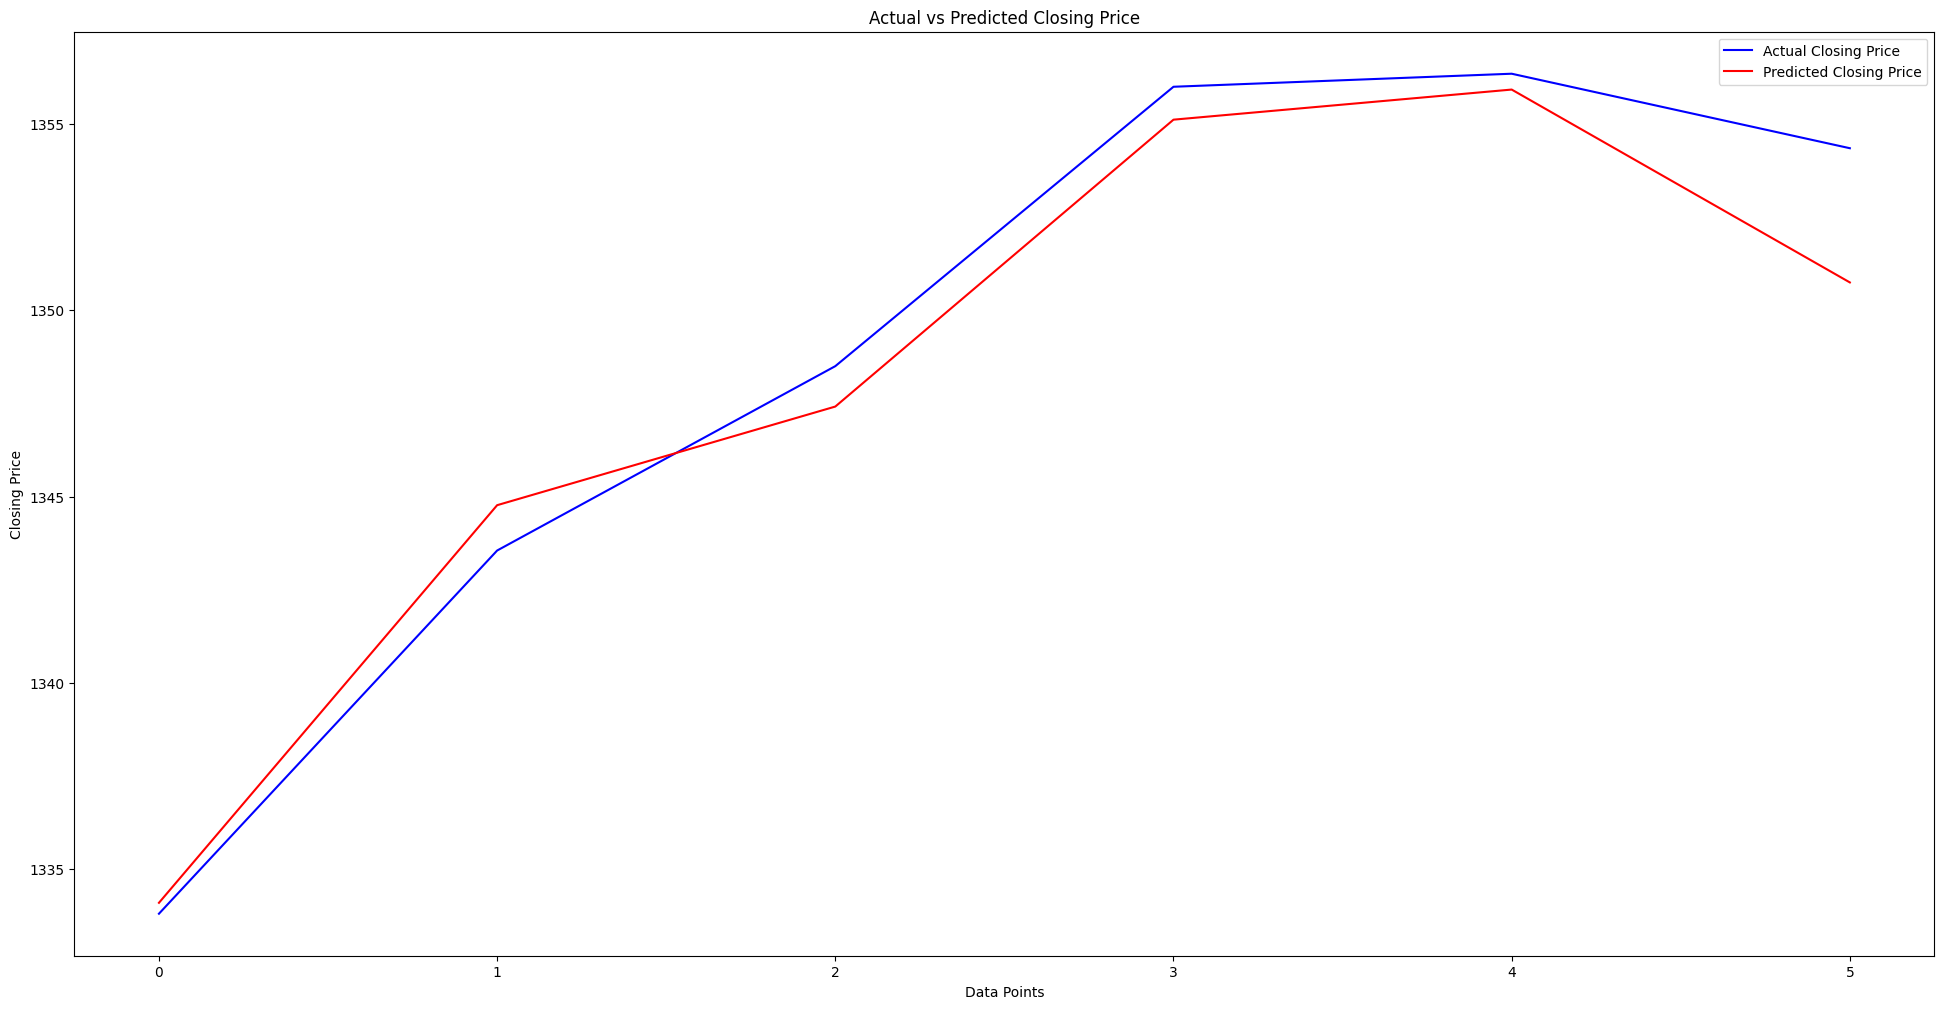

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, df_train_label)

# Make predictions on the test set
lin_predictions = lin_reg.predict(test_prepared)

# Evaluate the model
lin_mse = mean_squared_error(df_test_label, lin_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f'Mean Squared Error: {lin_rmse}')


# Visualize actual and predicted values with two different lines
plt.figure(figsize=(24, 12))
plt.plot(df_test_label.values, label='Actual Closing Price', color='blue')
plt.plot(lin_predictions, label='Predicted Closing Price', color='red')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

Use XGBoost model to predict the closing price on train data and calculate RMSE

RMSE: 1.3934649468201088


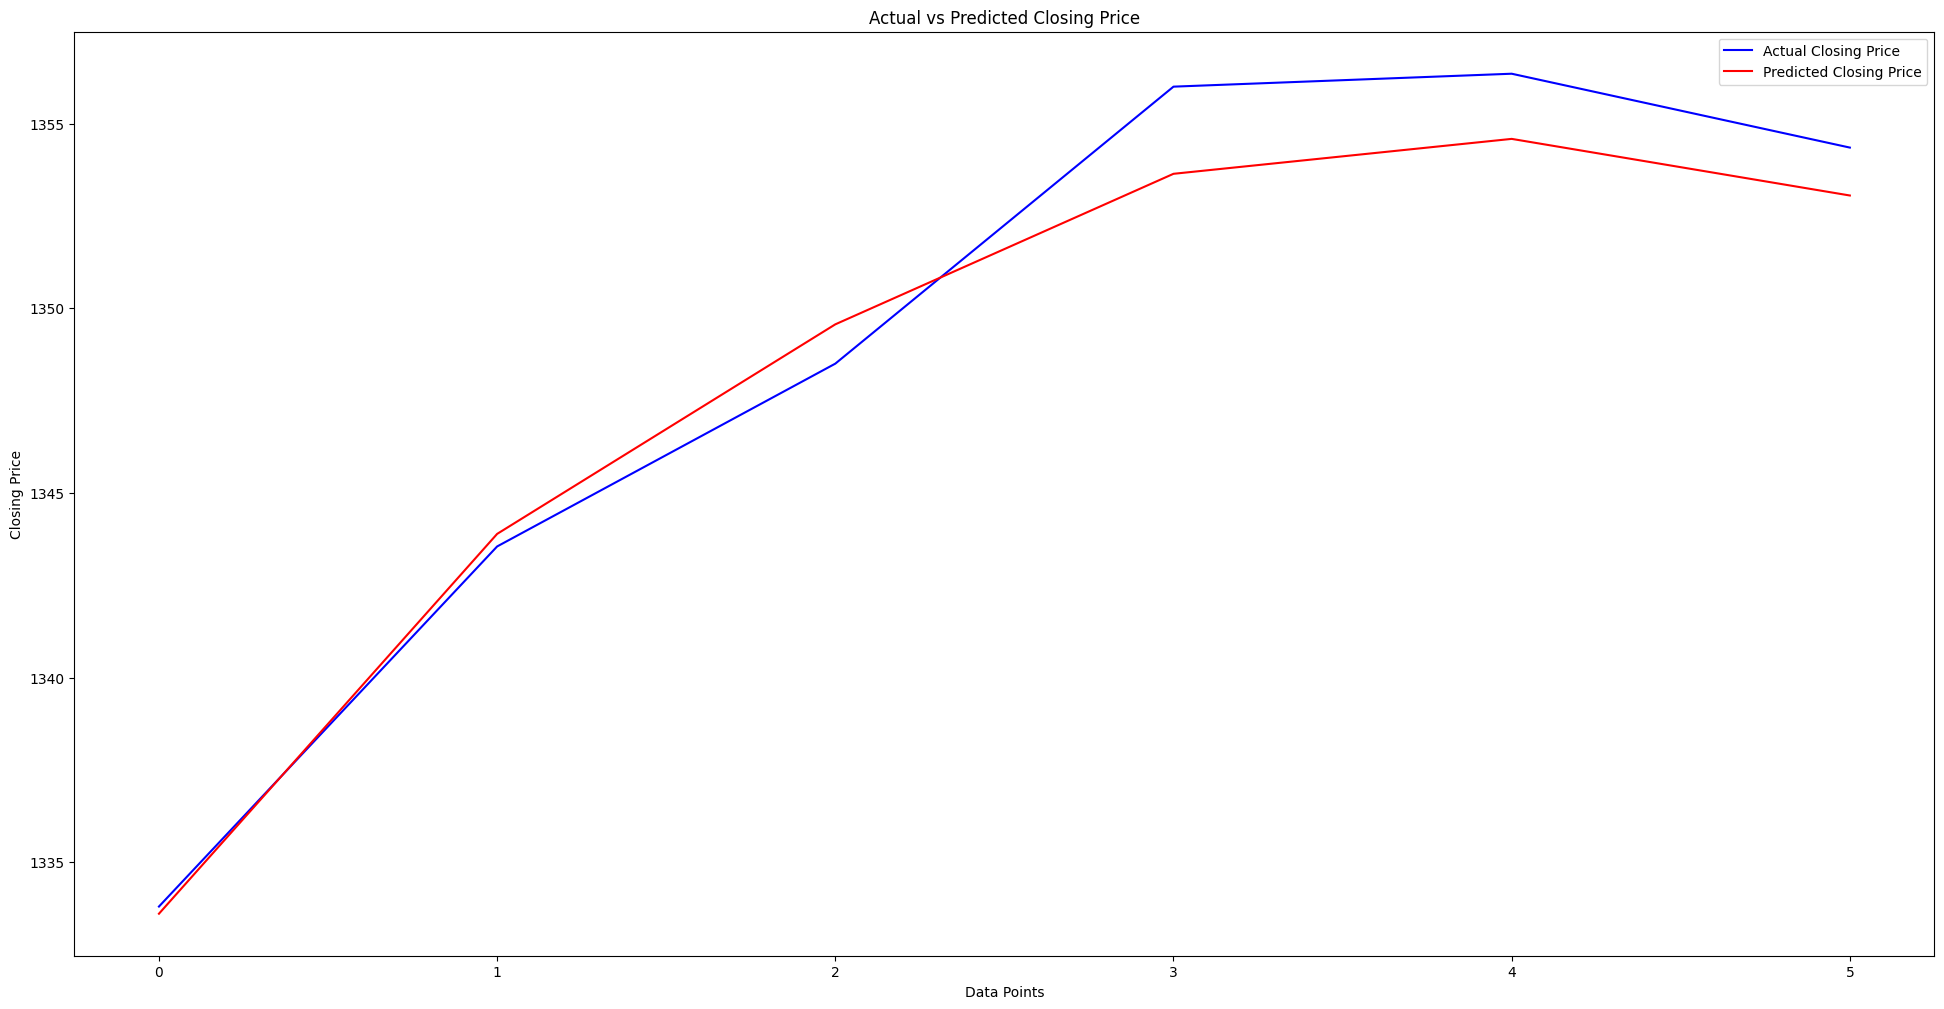

In [52]:
# Create an XGBoost regressor
XGmodel = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
XGmodel.fit(train_prepared, df_train_label)
XG_predictions = XGmodel.predict(test_prepared)

# Evaluate the model
XG_mse = mean_squared_error(df_test_label, XG_predictions)
rmse = np.sqrt(XG_mse)
print(f'RMSE: {rmse}')

# Visualize actual and predicted values with two different lines
plt.figure(figsize=(24, 12))
plt.plot(df_test_label.values, label='Actual Closing Price', color='blue')
plt.plot(XG_predictions, label='Predicted Closing Price', color='red')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()


Use tensorflow model to predict the closing price on train data and calculate RMSE



Epoch 1/50

18/18 [==============================] - 1s 4ms/step - loss: 815477.1875
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 812866.6250
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 808525.1250
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 800885.6250
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 787973.7500
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 768149.6250
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 738956.5000
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 698808.1250
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 648031.0625
Epoch 10/50
18/18 [==============================] - 0s 3ms/step - loss: 585020.4375
Epoch 11/50
18/18 [==============================] - 0s 3ms/step - loss: 514434.6875
Epoch 12/50
18/18 [==============================] - 0s 3ms/step - loss

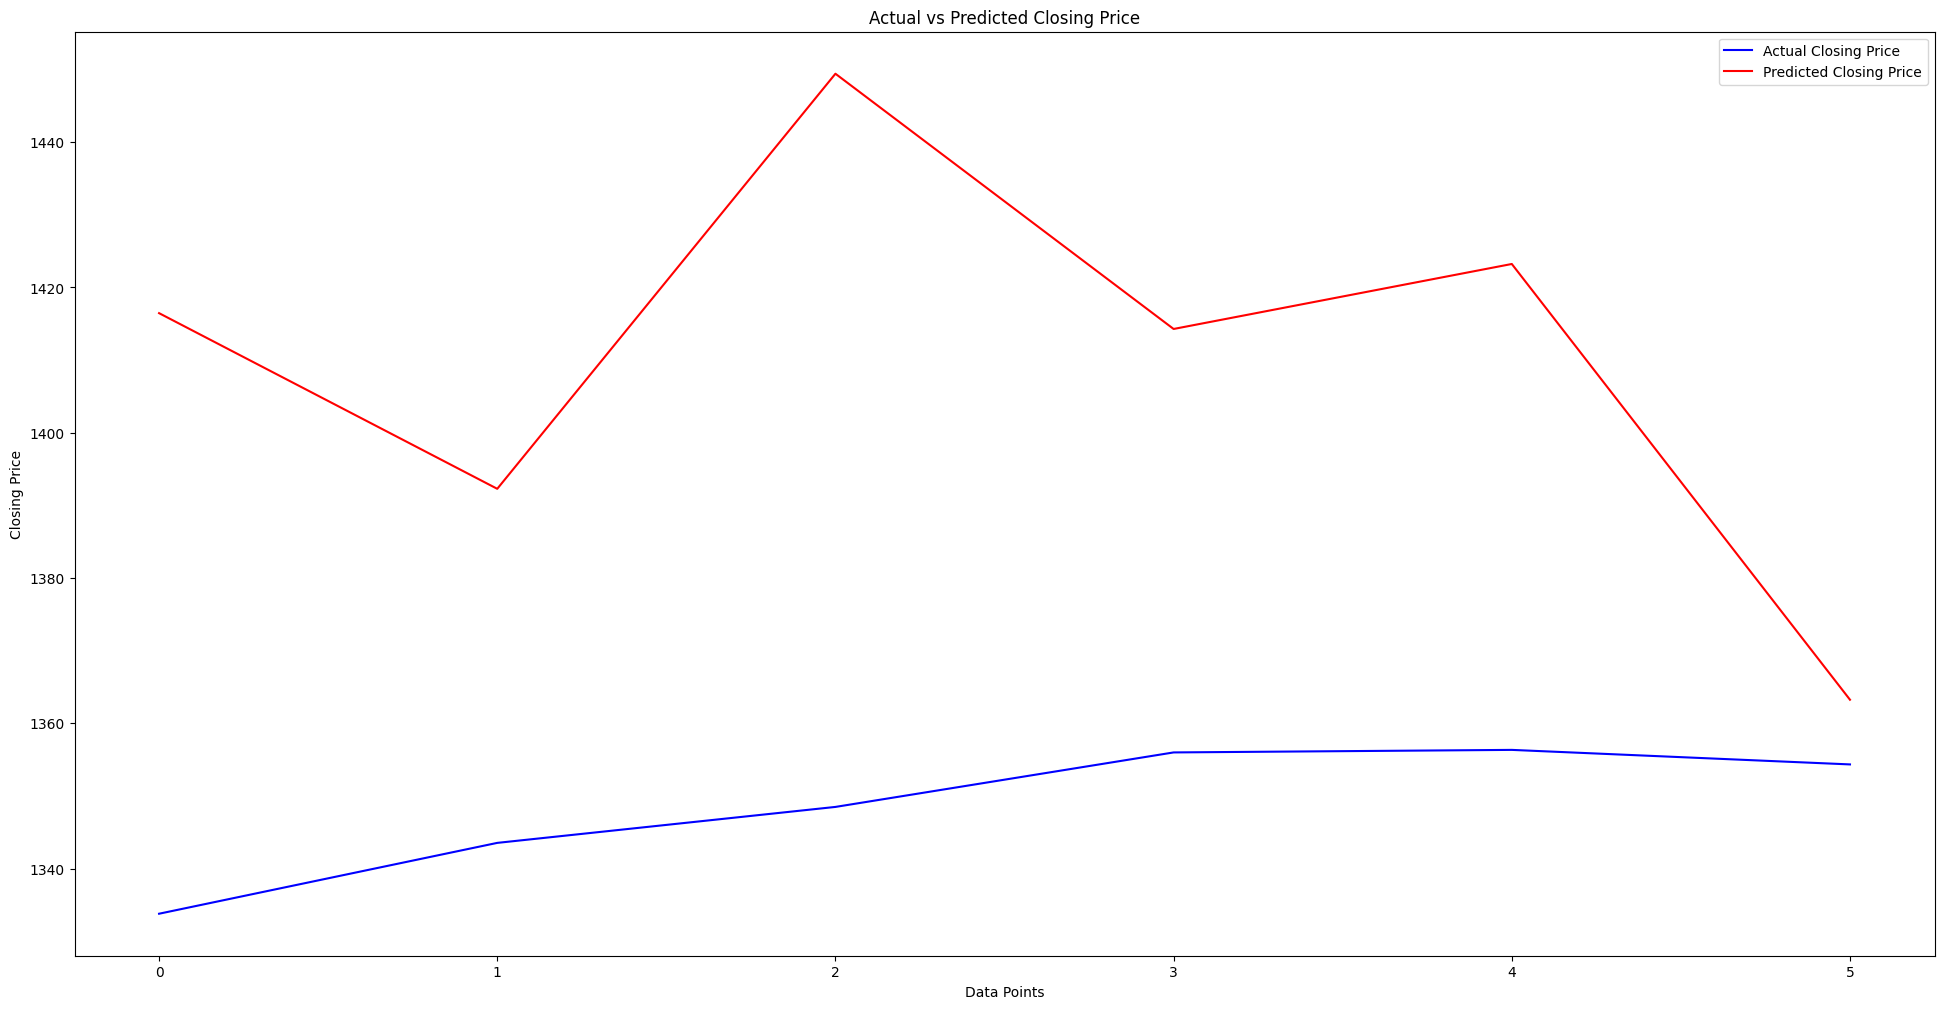

In [53]:
tf_model = Sequential()
tf_model.add(Dense(64, input_dim=train_prepared.shape[1], activation='relu'))
tf_model.add(Dense(32, activation='relu'))
tf_model.add(Dense(1, activation='linear'))

# Compile the model
tf_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
tf_model.fit(train_prepared, df_train_label, epochs=50, batch_size=32)

# Make predictions on the test set
tf_predictions = tf_model.predict(test_prepared)

# Evaluate the model
tf_mse = mean_squared_error(df_test_label, tf_predictions)
tf_rmse = np.sqrt(tf_mse)
print(f'RMSE - TF: {tf_rmse}')

# Visualize actual and predicted values with two different lines
plt.figure(figsize=(24, 12))
plt.plot(df_test_label.values, label='Actual Closing Price', color='blue')
plt.plot(tf_predictions, label='Predicted Closing Price', color='red')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

Linear Regression and XGBoost models emerged as clear winner here. Hence we will conclude the project with linear regression and XGBoost models

Linear Regression:

In [54]:
# Convert the linear prediction to panda's dataframe
lin_df_test = pd.DataFrame(data=lin_predictions, columns=["Predicted_close"])

# Reset the index in strat_test_set
test_set_reset = test_set.reset_index()

# Merge based on the index
final_lin_df = pd.merge(test_set_reset, lin_df_test, left_index=True, right_index=True, how='inner')

# Merge to get market sentiment
nifty_df_for_user = pd.merge(final_lin_df, df_combined_sentiments, on='Symbol', how='inner')

# Map sentiment to action
sentiment_to_action = {'Positive': 'Buy', 'Neutral': 'Hold', 'Negative': 'Sell'}

# Create a new column 'Action' based on the 'Overall_Sentiment'
nifty_df_for_user['Recommendation'] = nifty_df_for_user['Overall_Sentiment'].map(sentiment_to_action)

# Setting back the index to Date
nifty_df_for_user = nifty_df_for_user.set_index('Date')
nifty_df_for_user


,index,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover,Trades,Deliverable Volume,%Deliverble,rollMean,rollStd,Predicted_close,Industry,Overall_Sentiment,Recommendation
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-23,3456,INFY,EQ,1351.10,1343.00,1348.4,1331.00,1333.9,1333.80,1339.49,...,9.800000e+14,163801,4123289,0.5636,1388.195833,39.919228,1334.092714,Information Technology,Positive,Buy
2021-04-26,3457,INFY,EQ,1333.80,1332.25,1351.3,1321.00,1345.0,1343.55,1343.19,...,9.520000e+14,130375,4218129,0.5951,1382.570833,41.143035,1344.767152,Information Technology,Positive,Buy
2021-04-27,3458,INFY,EQ,1343.55,1346.00,1353.0,1340.15,1347.5,1348.50,1346.89,...,4.900000e+14,145974,1871084,0.5146,1375.762500,39.261693,1347.415089,Information Technology,Positive,Buy
2021-04-28,3459,INFY,EQ,1348.50,1358.00,1359.5,1344.60,1355.8,1356.00,1353.45,...,6.600000e+14,137376,2857134,0.5856,1368.775000,33.916653,1355.116544,Information Technology,Positive,Buy
2021-04-29,3460,INFY,EQ,1356.00,1368.00,1369.0,1351.40,1356.0,1356.35,1360.05,...,7.360000e+14,119277,3130945,0.5785,1361.716667,25.202086,1355.924804,Information Technology,Positive,Buy
2021-04-30,3461,INFY,EQ,1356.35,1346.30,1373.9,1345.90,1348.6,1354.35,1361.16,...,1.140000e+15,131718,5408113,0.6473,1355.766667,15.123031,1350.747209,Information Technology,Positive,Buy


XGBoost

In [55]:
# Convert the XGBoost prediction to panda's dataframe
xg_df_test = pd.DataFrame(data=XG_predictions, columns=["Predicted_close"])

# Reset the index in strat_test_set
test_set_reset = test_set.reset_index()

# Merge based on the index
final_xg_df = pd.merge(test_set_reset, xg_df_test, left_index=True, right_index=True, how='inner')

# Merge to get market sentiment
nifty_df_for_user = pd.merge(final_xg_df, df_combined_sentiments, on='Symbol', how='inner')

# Map sentiment to action
sentiment_to_action = {'Positive': 'Buy', 'Neutral': 'Hold', 'Negative': 'Sell'}

# Create a new column 'Action' based on the 'Overall_Sentiment'
nifty_df_for_user['Recommendation'] = nifty_df_for_user['Overall_Sentiment'].map(sentiment_to_action)

# Setting back the index to Date
nifty_df_for_user = nifty_df_for_user.set_index('Date')
nifty_df_for_user


,index,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover,Trades,Deliverable Volume,%Deliverble,rollMean,rollStd,Predicted_close,Industry,Overall_Sentiment,Recommendation
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-23,3456,INFY,EQ,1351.10,1343.00,1348.4,1331.00,1333.9,1333.80,1339.49,...,9.800000e+14,163801,4123289,0.5636,1388.195833,39.919228,1333.605591,Information Technology,Positive,Buy
2021-04-26,3457,INFY,EQ,1333.80,1332.25,1351.3,1321.00,1345.0,1343.55,1343.19,...,9.520000e+14,130375,4218129,0.5951,1382.570833,41.143035,1343.889771,Information Technology,Positive,Buy
2021-04-27,3458,INFY,EQ,1343.55,1346.00,1353.0,1340.15,1347.5,1348.50,1346.89,...,4.900000e+14,145974,1871084,0.5146,1375.762500,39.261693,1349.564087,Information Technology,Positive,Buy
2021-04-28,3459,INFY,EQ,1348.50,1358.00,1359.5,1344.60,1355.8,1356.00,1353.45,...,6.600000e+14,137376,2857134,0.5856,1368.775000,33.916653,1353.640137,Information Technology,Positive,Buy
2021-04-29,3460,INFY,EQ,1356.00,1368.00,1369.0,1351.40,1356.0,1356.35,1360.05,...,7.360000e+14,119277,3130945,0.5785,1361.716667,25.202086,1354.585693,Information Technology,Positive,Buy
2021-04-30,3461,INFY,EQ,1356.35,1346.30,1373.9,1345.90,1348.6,1354.35,1361.16,...,1.140000e+15,131718,5408113,0.6473,1355.766667,15.123031,1353.052612,Information Technology,Positive,Buy
